# **Model Comparison**

This notebook presents a comparative analysis of **model performance** and **model interpretability** between two different learning paradigms:

- A **Centralized Model** used as a baseline
- A **Federated Learning (FL) Model with Encrypted Weights**

The goal of this comparison is to understand the **trade-offs between privacy preservation and model effectiveness**, as well as how encryption impacts the interpretability of learned representations.

---

#

# Preparing Data and Helper Functions

In [4]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os

xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')
malakabdelaziz1556_efficientnetb0_fake_real_model3_final_tensorflow2_default_1_path = kagglehub.model_download('malakabdelaziz1556/efficientnetb0-fake-real-model3-final/TensorFlow2/default/1')
malakabdelaziz1556_fl_model_tensorflow2_default_1_path = kagglehub.model_download('malakabdelaziz1556/fl-model/TensorFlow2/default/1')
malakabdelaziz1556_fl_withencryption_tensorflow2_default_1_path = kagglehub.model_download('malakabdelaziz1556/fl-withencryption/TensorFlow2/default/1')

print('Data source import complete.')


Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.
Data source import complete.


In [6]:
print("Centeralized Model downloaded to:", malakabdelaziz1556_efficientnetb0_fake_real_model3_final_tensorflow2_default_1_path )
print("FL Model downloaded to:", malakabdelaziz1556_fl_model_tensorflow2_default_1_path)
print("FL Model with Encryption downloaded to:",malakabdelaziz1556_fl_withencryption_tensorflow2_default_1_path)
print("Dataset path exists:", os.path.exists(xhlulu_140k_real_and_fake_faces_path))

Centeralized Model downloaded to: /root/.cache/kagglehub/models/malakabdelaziz1556/efficientnetb0-fake-real-model3-final/TensorFlow2/default/1
FL Model downloaded to: /root/.cache/kagglehub/models/malakabdelaziz1556/fl-model/TensorFlow2/default/1
FL Model with Encryption downloaded to: /root/.cache/kagglehub/models/malakabdelaziz1556/fl-withencryption/TensorFlow2/default/1
Dataset path exists: True


## 1. Imports


In [7]:

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shap

# Optional: suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## 2. Define Paths


In [8]:

TEST_DIR = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"
REAL_DIR = os.path.join(TEST_DIR, "real")
FAKE_DIR = os.path.join(TEST_DIR, "fake")

CENTRALIZED_PATH="/root/.cache/kagglehub/models/malakabdelaziz1556/efficientnetb0-fake-real-model3-final/TensorFlow2/default/1/efficientnetb0_fake_real_model3_final.h5"

FEDERATED_PATH= "/root/.cache/kagglehub/models/malakabdelaziz1556/fl-model/TensorFlow2/default/1/flowerModelNoEncryption.h5"

FL_ENCRYPTED_PATH ="/root/.cache/kagglehub/models/malakabdelaziz1556/fl-withencryption/TensorFlow2/default/1"



## 3. Prepare Dataset for Evaluation


In [9]:
import os
import glob
import numpy as np

real_images = glob.glob(os.path.join(TEST_DIR, "real", "*"))
fake_images = glob.glob(os.path.join(TEST_DIR, "fake", "*"))

image_paths = real_images + fake_images

# Labels: Real = 1, Fake = 0
labels = [1] * len(real_images) + [0] * len(fake_images)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total test images: {len(image_paths)}")
print(f"Real images: {len(real_images)}")
print(f"Fake images: {len(fake_images)}")


Total test images: 20000
Real images: 10000
Fake images: 10000


## 4. Helper Function: Batch Image Processing


In [10]:
def process_images_batch(image_paths, labels, batch_size):
    images = []
    y = []

    for img_path, label in zip(image_paths, labels):
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(224, 224)
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.efficientnet.preprocess_input(img)

        images.append(img)
        y.append(label)

    return np.array(images), np.array(y)


# Centralized Model Evaluation

## 1. Load the Pre-trained Model

In [11]:
print("Loading model...")
try:
    centralized_model = tf.keras.models.load_model(CENTRALIZED_PATH, safe_mode=False)
except Exception as e:
    print(f"Failed loading model: {e}")
    custom_objects = {
        'Dense': lambda **kwargs: tf.keras.layers.Dense(
            **{k: v for k, v in kwargs.items() if k != 'quantization_config'}
        )
    }
    centralized_model = tf.keras.models.load_model(CENTRALIZED_PATH, custom_objects=custom_objects, safe_mode=False)

print("Model loaded successfully!")
print(f"Input shape: {centralized_model.input_shape}, Output shape: {centralized_model.output_shape}")


Loading model...
Failed loading model: Error when deserializing class 'Dense' using config={'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'quantization_config': None}.

Exception encountered: Unrecognized keyword arguments passed to Dense: {'quantization_config': None}


Model loaded successfully!
Input shape: (None, 224, 224, 3), Output shape: (None, 2)


## 2. Batch Predictions on Full Dataset


In [12]:

from sklearn.metrics import roc_auc_score

BATCH_SIZE = 256

y_true_all_centralized = []
y_pred_all_centralized = []
y_prob_all_centralized = []

print("Running streamed evaluation...")

for i in range(0, len(image_paths), BATCH_SIZE):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    batch_labels = labels[i:i+BATCH_SIZE]

    X_batch, y_batch = process_images_batch(
        batch_paths,
        batch_labels,
        batch_size=BATCH_SIZE
    )

    y_prob = centralized_model.predict(X_batch, verbose=0)

    # ---- Binary sigmoid model ----
    if y_prob.shape[-1] == 1:
        probs = y_prob.flatten()
        y_pred = (probs > 0.5).astype(int)

    # ---- Softmax model ----
    else:
        probs = y_prob[:, 1]
        y_pred = np.argmax(y_prob, axis=1)

    y_true_all_centralized.extend(y_batch)
    y_pred_all_centralized.extend(y_pred)
    y_prob_all_centralized.extend(probs)

    print(f"Processed {len(y_true_all_centralized)}/{len(image_paths)}")

# Convert to numpy
y_true_all = np.array(y_true_all_centralized)
y_pred_all = np.array(y_pred_all_centralized)
y_prob_all = np.array(y_prob_all_centralized)




Running streamed evaluation...
Processed 256/20000
Processed 512/20000
Processed 768/20000
Processed 1024/20000
Processed 1280/20000
Processed 1536/20000
Processed 1792/20000
Processed 2048/20000
Processed 2304/20000
Processed 2560/20000
Processed 2816/20000
Processed 3072/20000
Processed 3328/20000
Processed 3584/20000
Processed 3840/20000
Processed 4096/20000
Processed 4352/20000
Processed 4608/20000
Processed 4864/20000
Processed 5120/20000
Processed 5376/20000
Processed 5632/20000
Processed 5888/20000
Processed 6144/20000
Processed 6400/20000
Processed 6656/20000
Processed 6912/20000
Processed 7168/20000
Processed 7424/20000
Processed 7680/20000
Processed 7936/20000
Processed 8192/20000
Processed 8448/20000
Processed 8704/20000
Processed 8960/20000
Processed 9216/20000
Processed 9472/20000
Processed 9728/20000
Processed 9984/20000
Processed 10240/20000
Processed 10496/20000
Processed 10752/20000
Processed 11008/20000
Processed 11264/20000
Processed 11520/20000
Processed 11776/20000

## 3. Evaluation Metrics


In [13]:
acc_centralized = accuracy_score(y_true_all_centralized, y_pred_all_centralized)
prec_centralized = precision_score(y_true_all_centralized, y_pred_all_centralized)
rec_centralized = recall_score(y_true_all_centralized, y_pred_all_centralized)
f1_centralized = f1_score(y_true_all_centralized, y_pred_all_centralized)
auc_centralized = roc_auc_score(y_true_all_centralized, y_prob_all_centralized)
cm_centralized = confusion_matrix(y_true_all_centralized, y_pred_all_centralized)

metrics_centralized = {
    "accuracy": acc_centralized,
    "precision": prec_centralized,
    "recall": rec_centralized,
    "f1": f1_centralized,
    "auc": auc_centralized
}

print(f"\nAccuracy:  {acc_centralized:.4f}")
print(f"Precision: {prec_centralized:.4f}")
print(f"Recall:    {rec_centralized:.4f}")
print(f"F1-score:  {f1_centralized:.4f}\n")
print(f"ROC–AUC:   {auc_centralized:.4f}\n")


print("Confusion Matrix:")
print(f"          Predicted Real  Predicted Fake")
print(f"Actual Real   {cm_centralized[1,1]:>10}         {cm_centralized[1,0]:>10}")
print(f"Actual Fake   {cm_centralized[0,1]:>10}         {cm_centralized[0,0]:>10}")


print("\nClassification Report:")
print(classification_report(y_true_all_centralized, y_pred_all_centralized, target_names=["Fake", "Real"]))



Accuracy:  0.8256
Precision: 0.7747
Recall:    0.9184
F1-score:  0.8404

ROC–AUC:   0.9279

Confusion Matrix:
          Predicted Real  Predicted Fake
Actual Real         9184                816
Actual Fake         2671               7329

Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.73      0.81     10000
        Real       0.77      0.92      0.84     10000

    accuracy                           0.83     20000
   macro avg       0.84      0.83      0.82     20000
weighted avg       0.84      0.83      0.82     20000



# Federated Model Evaluation


## 1. Load the Pre-trained Model

In [14]:
print("Loading model...")
try:
    federated_model = tf.keras.models.load_model(FEDERATED_PATH, safe_mode=False)
except Exception as e:
    print(f"Failed loading model: {e}")
    custom_objects = {
        'Dense': lambda **kwargs: tf.keras.layers.Dense(
            **{k: v for k, v in kwargs.items() if k != 'quantization_config'}
        )
    }
    federated_model = tf.keras.models.load_model(FEDERATED_PATH, custom_objects=custom_objects, safe_mode=False)

print("Model loaded successfully!")
print(f"Input shape: {federated_model.input_shape}, Output shape: {federated_model.output_shape}")


Loading model...
Failed loading model: Error when deserializing class 'Dense' using config={'name': 'dense_2', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'quantization_config': None}.

Exception encountered: Unrecognized keyword arguments passed to Dense: {'quantization_config': None}


Model loaded successfully!
Input shape: (None, 224, 224, 3), Output shape: (None, 2)


##2. Batch Predictions on Full Dataset

In [15]:

from sklearn.metrics import roc_auc_score

BATCH_SIZE = 256

y_true_all_FL = []
y_pred_all_FL = []
y_prob_all_FL = []

print("Running streamed evaluation...")

for i in range(0, len(image_paths), BATCH_SIZE):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    batch_labels = labels[i:i+BATCH_SIZE]

    X_batch, y_batch = process_images_batch(
        batch_paths,
        batch_labels,
        batch_size=BATCH_SIZE
    )

    y_prob = federated_model.predict(X_batch, verbose=0)

    # ---- Binary sigmoid model ----
    if y_prob.shape[-1] == 1:
        probs = y_prob.flatten()
        y_pred = (probs > 0.5).astype(int)

    # ---- Softmax model ----
    else:
        probs = y_prob[:, 1]
        y_pred = np.argmax(y_prob, axis=1)

    y_true_all_FL.extend(y_batch)
    y_pred_all_FL.extend(y_pred)
    y_prob_all_FL.extend(probs)

    print(f"Processed {len(y_true_all_FL)}/{len(image_paths)}")

# Convert to numpy
y_true_all_FL = np.array(y_true_all_FL)
y_pred_all_FL = np.array(y_pred_all_FL)
y_prob_all_FL = np.array(y_prob_all_FL)




Running streamed evaluation...
Processed 256/20000
Processed 512/20000
Processed 768/20000
Processed 1024/20000
Processed 1280/20000
Processed 1536/20000
Processed 1792/20000
Processed 2048/20000
Processed 2304/20000
Processed 2560/20000
Processed 2816/20000
Processed 3072/20000
Processed 3328/20000
Processed 3584/20000
Processed 3840/20000
Processed 4096/20000
Processed 4352/20000
Processed 4608/20000
Processed 4864/20000
Processed 5120/20000
Processed 5376/20000
Processed 5632/20000
Processed 5888/20000
Processed 6144/20000
Processed 6400/20000
Processed 6656/20000
Processed 6912/20000
Processed 7168/20000
Processed 7424/20000
Processed 7680/20000
Processed 7936/20000
Processed 8192/20000
Processed 8448/20000
Processed 8704/20000
Processed 8960/20000
Processed 9216/20000
Processed 9472/20000
Processed 9728/20000
Processed 9984/20000
Processed 10240/20000
Processed 10496/20000
Processed 10752/20000
Processed 11008/20000
Processed 11264/20000
Processed 11520/20000
Processed 11776/20000

## 3. Evaluation Metrics

In [16]:
acc_FL = accuracy_score(y_true_all_FL, y_pred_all_FL)
prec_FL = precision_score(y_true_all_FL, y_pred_all_FL)
rec_FL = recall_score(y_true_all_FL, y_pred_all_FL)
f1_FL = f1_score(y_true_all_FL, y_pred_all_FL)
auc_FL = roc_auc_score(y_true_all_FL, y_prob_all_FL)
cm_FL = confusion_matrix(y_true_all_FL, y_pred_all_FL)


metrics_FL = {
    "accuracy": acc_FL,
    "precision": prec_FL,
    "recall": rec_FL,
    "f1": f1_FL,
    "auc": auc_FL
}


print(f"\nAccuracy:  {acc_FL:.4f}")
print(f"Precision: {prec_FL:.4f}")
print(f"Recall:    {rec_FL:.4f}")
print(f"F1-score:  {f1_FL:.4f}\n")
print(f"ROC–AUC:   {auc_FL:.4f}\n")

print("Confusion Matrix:")
print(f"          Predicted Real  Predicted Fake")
print(f"Actual Real   {cm_FL[1,1]:>10}         {cm_FL[1,0]:>10}")
print(f"Actual Fake   {cm_FL[0,1]:>10}         {cm_FL[0,0]:>10}")

print("\nClassification Report:")
print(classification_report(y_true_all_FL, y_pred_all_FL, target_names=["Fake", "Real"]))


Accuracy:  0.7412
Precision: 0.6658
Recall:    0.9686
F1-score:  0.7891

ROC–AUC:   0.9211

Confusion Matrix:
          Predicted Real  Predicted Fake
Actual Real         9686                314
Actual Fake         4862               5138

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.51      0.67     10000
        Real       0.67      0.97      0.79     10000

    accuracy                           0.74     20000
   macro avg       0.80      0.74      0.73     20000
weighted avg       0.80      0.74      0.73     20000



# Federated Model with Encryption

## 1. Load the Pre-trained Model

In [17]:
print("Loading model...")
try:
    encrypted_model = tf.keras.models.load_model(FEDERATED_PATH, safe_mode=False)
except Exception as e:
    print(f"Failed loading model: {e}")
    custom_objects = {
        'Dense': lambda **kwargs: tf.keras.layers.Dense(
            **{k: v for k, v in kwargs.items() if k != 'quantization_config'}
        )
    }
    encrypted_model = tf.keras.models.load_model(FEDERATED_PATH, custom_objects=custom_objects, safe_mode=False)

print("Model loaded successfully!")
print(f"Input shape: {encrypted_model.input_shape}, Output shape: {encrypted_model.output_shape}")


Loading model...
Failed loading model: Error when deserializing class 'Dense' using config={'name': 'dense_2', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'quantization_config': None}.

Exception encountered: Unrecognized keyword arguments passed to Dense: {'quantization_config': None}


Model loaded successfully!
Input shape: (None, 224, 224, 3), Output shape: (None, 2)


##2. Batch Predictions on Full Dataset

In [18]:
from sklearn.metrics import roc_auc_score

BATCH_SIZE = 256

y_true_all_FL_en = []
y_pred_all_FL_en = []
y_prob_all_FL_en = []

print("Running streamed evaluation...")

for i in range(0, len(image_paths), BATCH_SIZE):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    batch_labels = labels[i:i+BATCH_SIZE]

    X_batch, y_batch = process_images_batch(
        batch_paths,
        batch_labels,
        batch_size=BATCH_SIZE
    )

    y_prob = encrypted_model.predict(X_batch, verbose=0)

    # ---- Binary sigmoid model ----
    if y_prob.shape[-1] == 1:
        probs = y_prob.flatten()
        y_pred = (probs > 0.5).astype(int)

    # ---- Softmax model ----
    else:
        probs = y_prob[:, 1]
        y_pred = np.argmax(y_prob, axis=1)

    y_true_all_FL_en.extend(y_batch)
    y_pred_all_FL_en.extend(y_pred)
    y_prob_all_FL_en.extend(probs)

    print(f"Processed {len(y_true_all_FL_en)}/{len(image_paths)}")

# Convert to numpy
y_true_all_FL_en = np.array(y_true_all_FL_en)
y_pred_all_FL_en = np.array(y_pred_all_FL_en)
y_prob_all_FL_en = np.array(y_prob_all_FL_en)

Running streamed evaluation...
Processed 256/20000
Processed 512/20000
Processed 768/20000
Processed 1024/20000
Processed 1280/20000
Processed 1536/20000
Processed 1792/20000
Processed 2048/20000
Processed 2304/20000
Processed 2560/20000
Processed 2816/20000
Processed 3072/20000
Processed 3328/20000
Processed 3584/20000
Processed 3840/20000
Processed 4096/20000
Processed 4352/20000
Processed 4608/20000
Processed 4864/20000
Processed 5120/20000
Processed 5376/20000
Processed 5632/20000
Processed 5888/20000
Processed 6144/20000
Processed 6400/20000
Processed 6656/20000
Processed 6912/20000
Processed 7168/20000
Processed 7424/20000
Processed 7680/20000
Processed 7936/20000
Processed 8192/20000
Processed 8448/20000
Processed 8704/20000
Processed 8960/20000
Processed 9216/20000
Processed 9472/20000
Processed 9728/20000
Processed 9984/20000
Processed 10240/20000
Processed 10496/20000
Processed 10752/20000
Processed 11008/20000
Processed 11264/20000
Processed 11520/20000
Processed 11776/20000

## 3. Evaluation Metrics

In [19]:
acc_FL_en = accuracy_score(y_true_all_FL_en, y_pred_all_FL_en)
prec_FL_en = precision_score(y_true_all_FL_en, y_pred_all_FL_en)
rec_FL_en = recall_score(y_true_all_FL_en, y_pred_all_FL_en)
f1_FL_en = f1_score(y_true_all_FL_en, y_pred_all_FL_en)
auc_FL_en = roc_auc_score(y_true_all_FL_en, y_prob_all_FL_en)
cm_FL_en = confusion_matrix(y_true_all_FL_en, y_pred_all_FL_en)

metrics_FL_en = {
    "accuracy": acc_FL_en,
    "precision": prec_FL_en,
    "recall": rec_FL_en,
    "f1": f1_FL_en,
    "auc": auc_FL_en
}

print(f"\nAccuracy:  {acc_FL_en:.4f}")
print(f"Precision: {prec_FL_en:.4f}")
print(f"Recall:    {rec_FL_en:.4f}")
print(f"F1-score:  {f1_FL_en:.4f}\n")
print(f"ROC–AUC:   {auc_FL_en:.4f}\n")

print("Confusion Matrix:")
print(f"          Predicted Real  Predicted Fake")
print(f"Actual Real   {cm_FL_en[1,1]:>10}         {cm_FL_en[1,0]:>10}")
print(f"Actual Fake   {cm_FL_en[0,1]:>10}         {cm_FL_en[0,0]:>10}")

print("\nClassification Report:")
print(classification_report(
    y_true_all_FL_en,
    y_pred_all_FL_en,
    target_names=["Fake", "Real"]
))




Accuracy:  0.7412
Precision: 0.6658
Recall:    0.9686
F1-score:  0.7891

ROC–AUC:   0.9211

Confusion Matrix:
          Predicted Real  Predicted Fake
Actual Real         9686                314
Actual Fake         4862               5138

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.51      0.67     10000
        Real       0.67      0.97      0.79     10000

    accuracy                           0.74     20000
   macro avg       0.80      0.74      0.73     20000
weighted avg       0.80      0.74      0.73     20000



# Comparision Analysis and Visiualization

##  1. Bar Plot for Metrics Comparison

In [20]:
import matplotlib.pyplot as plt
import numpy as np

metrics_dict = {
    "Centralized": metrics_centralized,
    "FL": metrics_FL,
    "FL_en": metrics_FL_en
}

def plot_model_comparison(metrics_dict, models_to_show):
    metric_keys = ["accuracy", "precision", "recall", "f1", "auc"]
    metric_labels = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]

    x = np.arange(len(metric_keys))
    width = 0.25 if len(models_to_show) == 3 else 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    for idx, model_name in enumerate(models_to_show):
        scores = [metrics_dict[model_name][k] for k in metric_keys]
        bars = ax.bar(
            x + (idx - (len(models_to_show)-1)/2) * width,
            scores,
            width,
            label=model_name
        )

        # Value labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.3f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=9
            )

    ax.set_xlabel("Metrics", fontsize=12)
    ax.set_ylabel("Scores", fontsize=12)
    ax.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, fontsize=11)
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.show()

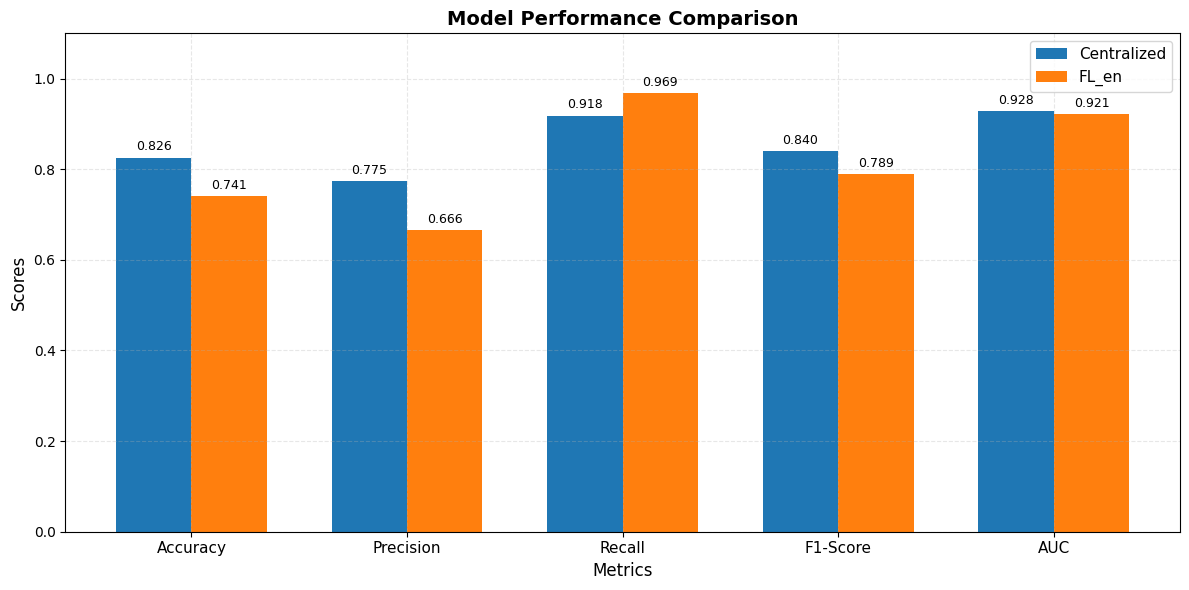

In [22]:
plot_model_comparison(
    metrics_dict,
    models_to_show=["Centralized", "FL_en"]
)

## 2. Radar/Spider Chart Comparison

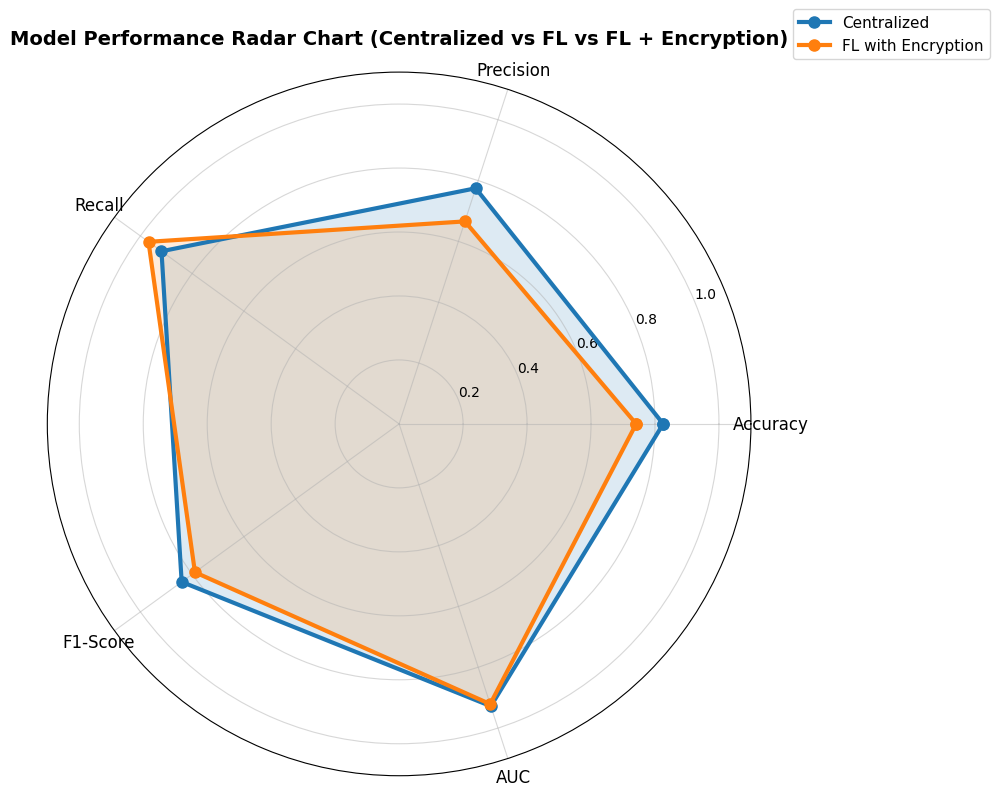

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Categories
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
N = len(categories)

# Angles for radar chart
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Extract values from metrics dictionaries
centralized_values = [metrics_centralized[k] for k in metric_keys]
FL_values = [metrics_FL[k] for k in metric_keys]
FL_en_values = [metrics_FL_en[k] for k in metric_keys]

# Close the loop
centralized_values += centralized_values[:1]
FL_values += FL_values[:1]
FL_en_values += FL_en_values[:1]

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Plot Centralized
ax.plot(angles, centralized_values, 'o-', linewidth=3,
        label='Centralized', markersize=8)
ax.fill(angles, centralized_values, alpha=0.15)

# Plot FL_en
ax.plot(angles, FL_en_values, 'o-', linewidth=3,
        label='FL with Encryption', markersize=8)
ax.fill(angles, FL_en_values, alpha=0.15)

# Category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Y-axis settings
ax.set_ylim(0, 1.1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.5)

# Title & legend
plt.title(
    'Model Performance Radar Chart (Centralized vs FL vs FL + Encryption)',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=11)

plt.tight_layout()
plt.show()

## 3. Confusion Matrices Comparison

/tmp/ipython-input-2101621090.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(metrics, rotation=45, ha='right')


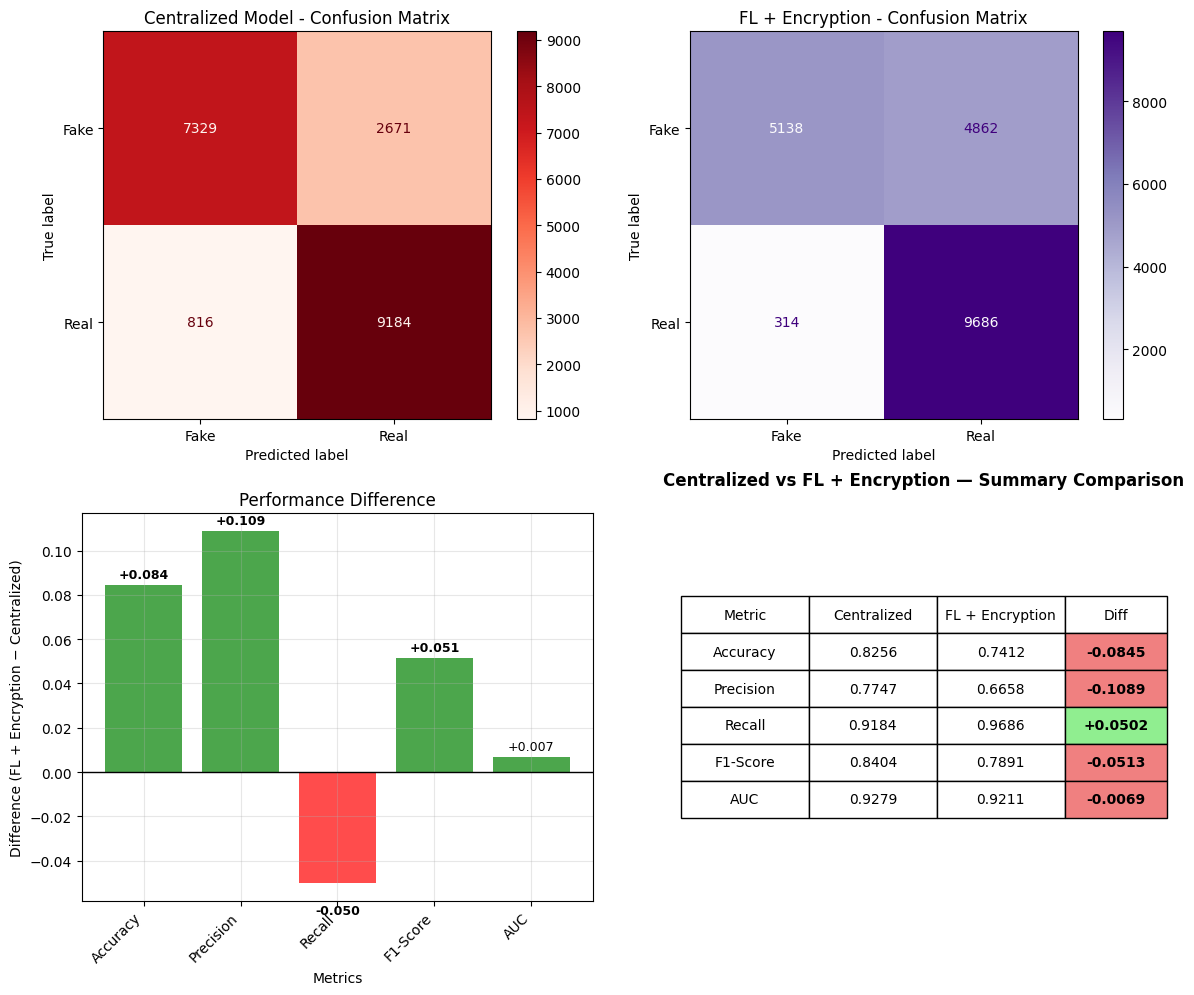

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# -------------------------------------------------
# 1. Confusion Matrix — Centralized
# -------------------------------------------------
ax1 = axes[0, 0]
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_centralized,
    display_labels=["Fake", "Real"]
)
disp1.plot(ax=ax1, cmap='Reds')
ax1.set_title('Centralized Model - Confusion Matrix')

# -------------------------------------------------
# 2. Confusion Matrix — FL + Encryption
# -------------------------------------------------
ax2 = axes[0, 1]
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_FL_en,
    display_labels=["Fake", "Real"]
)
disp2.plot(ax=ax2, cmap='Purples')
ax2.set_title('FL + Encryption - Confusion Matrix')

# -------------------------------------------------
# 3. Metric differences (FL_en − Centralized)
# -------------------------------------------------
ax3 = axes[1, 0]

# Differences between FL with Encryption and Centralized

differences = [
    acc_centralized  - acc_FL_en,
    prec_centralized - prec_FL_en,
    rec_centralized  - rec_FL_en,
    f1_centralized   - f1_FL_en,
    auc_centralized  - auc_FL_en
]


colors = ['green' if diff > 0 else 'red' for diff in differences]

bars_diff = ax3.bar(metrics, differences, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linewidth=1)
ax3.set_xlabel('Metrics')
ax3.set_ylabel('Difference (FL + Encryption − Centralized)')
ax3.set_title('Performance Difference')
ax3.set_xticklabels(metrics, rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

for bar, diff in zip(bars_diff, differences):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    ytext = 3 if height >= 0 else -15
    ax3.annotate(
        f'{diff:+.3f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, ytext),
        textcoords="offset points",
        ha='center', va=va,
        fontsize=9,
        fontweight='bold' if abs(diff) > 0.05 else 'normal'
    )

# -------------------------------------------------
# 4. Summary table
# -------------------------------------------------
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

table_data = [
    ['Metric', 'Centralized', 'FL + Encryption', 'Diff'],
    ['Accuracy',  f'{acc_centralized:.4f}',  f'{acc_FL_en:.4f}',  f'{acc_FL_en-acc_centralized:+.4f}'],
    ['Precision', f'{prec_centralized:.4f}', f'{prec_FL_en:.4f}', f'{prec_FL_en-prec_centralized:+.4f}'],
    ['Recall',    f'{rec_centralized:.4f}',  f'{rec_FL_en:.4f}',  f'{rec_FL_en-rec_centralized:+.4f}'],
    ['F1-Score',  f'{f1_centralized:.4f}',   f'{f1_FL_en:.4f}',   f'{f1_FL_en-f1_centralized:+.4f}'],
    ['AUC',       f'{auc_centralized:.4f}',  f'{auc_FL_en:.4f}',  f'{auc_FL_en-auc_centralized:+.4f}']
]

colors_table = [['white', 'white', 'white', 'white']]
for i in range(1, len(table_data)):
    diff_val = float(table_data[i][3])
    color = 'lightgreen' if diff_val > 0 else 'lightcoral' if diff_val < 0 else 'white'
    colors_table.append(['white', 'white', 'white', color])

table = ax4.table(
    cellText=table_data,
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.25, 0.25, 0.2]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(table_data)):
    for j in range(4):
        table[(i, j)].set_facecolor(colors_table[i][j])
        if j == 3 and i > 0:
            table[(i, j)].set_text_props(weight='bold')

ax4.set_title('Centralized vs FL + Encryption — Summary Comparison',
              fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## 4. ROC Curves Comparison


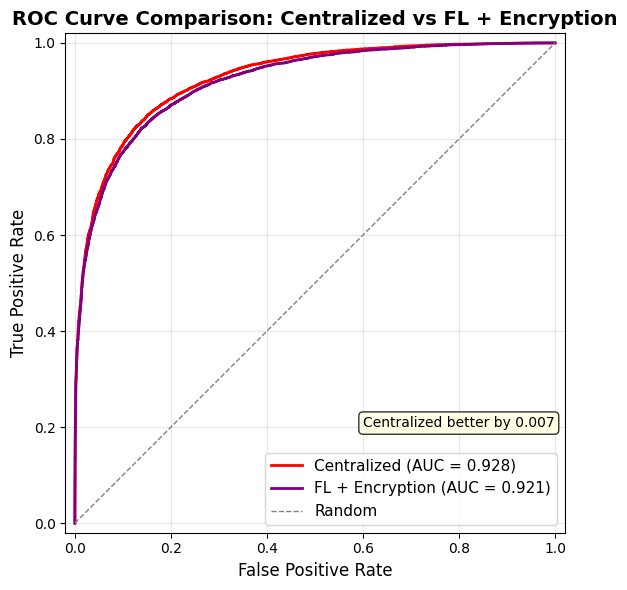

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC and AUC for Centralized
fpr_c, tpr_c, _ = roc_curve(y_true_all_centralized, y_prob_all_centralized)
auc_c = roc_auc_score(y_true_all_centralized, y_prob_all_centralized)

# Compute ROC and AUC for FL + Encryption
fpr_flen, tpr_flen, _ = roc_curve(y_true_all_FL_en, y_prob_all_FL_en)
auc_flen = roc_auc_score(y_true_all_FL_en, y_prob_all_FL_en)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_c, tpr_c, color='red', lw=2, label=f'Centralized (AUC = {auc_c:.3f})')
ax.plot(fpr_flen, tpr_flen, color='purple', lw=2, label=f'FL + Encryption (AUC = {auc_flen:.3f})')

# Random baseline
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

# Styling
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison: Centralized vs FL + Encryption', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_aspect('equal', adjustable='box')

# Optional: Highlight which model is better
if auc_c > auc_flen:
    better_text = f'Centralized better by {auc_c - auc_flen:.3f}'
else:
    better_text = f'FL + Encryption better by {auc_flen - auc_c:.3f}'

ax.text(0.6, 0.2, better_text,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
plt.show()

# Explainable AI (XAI)

In [46]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random
import tensorflow as tf


In [63]:

# ============================
# Random seed for reproducibility
# ============================
random.seed(42)

# ============================
# Collect all test image paths
# ============================
fake_paths = [
    os.path.join(FAKE_DIR, f)
    for f in os.listdir(FAKE_DIR)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

real_paths = [
    os.path.join(REAL_DIR, f)
    for f in os.listdir(REAL_DIR)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Labels
fake_labels = [0] * len(fake_paths)   # Fake = 0
real_labels = [1] * len(real_paths)   # Real = 1

# Combine and shuffle
combined = list(zip(real_paths + fake_paths, real_labels + fake_labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)
image_paths = list(image_paths)
labels = list(labels)

print(
    f"Evaluating on test set: {len(image_paths)} images "
    f"(Fake: {labels.count(0)}, Real: {labels.count(1)})"
)

# ============================
# Sample sizes
# ============================
BACKGROUND_SAMPLES = 300
TEST_SAMPLES = 100

# ============================
# Background samples (from test folder)
# ============================
bg_paths   = image_paths[:BACKGROUND_SAMPLES]
bg_labels  = labels[:BACKGROUND_SAMPLES]

# ============================
# Fixed test samples (from test folder)
# ============================
test_paths  = image_paths[BACKGROUND_SAMPLES:BACKGROUND_SAMPLES+TEST_SAMPLES]
test_labels = labels[BACKGROUND_SAMPLES:BACKGROUND_SAMPLES+TEST_SAMPLES]

# ============================
# Preprocess images
# ============================
X_background, _ = process_images_batch(bg_paths, bg_labels, batch_size=BACKGROUND_SAMPLES)
X_test, y_test  = process_images_batch(test_paths, test_labels, batch_size=TEST_SAMPLES)


Evaluating on test set: 20000 images (Fake: 10000, Real: 10000)


In [64]:
def compute_shap_values(model, background, test_samples):
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(test_samples)

    # Handle binary / multiclass output
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    return shap_values


In [65]:
print("Generating SHAP for centralized model...")
shap_central = compute_shap_values(
    centralized_model, X_background, X_test
)

print("Generating SHAP for federated model...")
shap_federated = compute_shap_values(
    encrypted_model, X_background, X_test
)


Generating SHAP for centralized model...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(100, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


Generating SHAP for federated model...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(100, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


In [66]:
global_shap_central= np.mean(np.abs(shap_central), axis=0)
global_shap_federated= np.mean(np.abs(shap_federated), axis=0)


In [67]:
similarity = cosine_similarity(
    global_shap_central.flatten().reshape(1, -1),
    global_shap_federated.flatten().reshape(1, -1)
)[0][0]

print(f"SHAP Cosine Similarity: {similarity:.4f}")
print(f"Mean |SHAP| Centralized: {np.mean(global_shap_central):.6f}")
print(f"Mean |SHAP| Federated:   {np.mean(global_shap_federated):.6f}")


SHAP Cosine Similarity: 0.9961
Mean |SHAP| Centralized: 0.000246
Mean |SHAP| Federated:   0.000191


In [68]:
th_central = np.percentile(global_shap_central, 90)
th_federated = np.percentile(global_shap_federated, 90)

top_central = np.sum(global_shap_central > th_central)
top_federated = np.sum(global_shap_federated > th_federated)

print(f"Top-10% Pixels Centralized: {top_central}")
print(f"Top-10% Pixels Federated:   {top_federated}")


Top-10% Pixels Centralized: 30106
Top-10% Pixels Federated:   30106


In [99]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# ===== IMPROVED VISUALIZATION FUNCTION =====
def visualize_comparison(idx, X_test, y_test,
                        centralized_model, federated_model,
                        shap_central, shap_federated,
                        global_shap_central, global_shap_federated):
    """
    Comprehensive visualization comparing centralized vs federated models
    """
    # Get predictions
    pred_central = centralized_model.predict(X_test[idx:idx+1], verbose=0)
    pred_federated = federated_model.predict(X_test[idx:idx+1], verbose=0)

    # Get predicted classes
    pred_class_central = np.argmax(pred_central, axis=1)[0] if pred_central.shape[1] > 1 else int(pred_central[0][0] > 0.5)
    pred_class_federated = np.argmax(pred_federated, axis=1)[0] if pred_federated.shape[1] > 1 else int(pred_federated[0][0] > 0.5)

    # Get prediction probabilities
    pred_prob_central = pred_central[0][pred_class_central] if pred_central.shape[1] > 1 else pred_central[0][0]
    pred_prob_federated = pred_federated[0][pred_class_federated] if pred_federated.shape[1] > 1 else pred_federated[0][0]

    # Get true label
    true_label = np.argmax(y_test[idx]) if len(y_test[idx].shape) > 0 and y_test[idx].shape[0] > 1 else int(y_test[idx])

    # Prepare SHAP values (sum across color channels)
    shap_central_sample = np.sum(np.abs(shap_central[idx]), axis=-1)
    shap_federated_sample = np.sum(np.abs(shap_federated[idx]), axis=-1)

    # Global SHAP
    global_shap_central_2d = np.sum(global_shap_central, axis=-1)
    global_shap_federated_2d = np.sum(global_shap_federated, axis=-1)

    # Normalize for visualization
    def normalize_minmax(arr):
        arr_min, arr_max = arr.min(), arr.max()
        if arr_max - arr_min == 0:
            return np.zeros_like(arr)
        return (arr - arr_min) / (arr_max - arr_min)

    # Normalize each
    shap_central_norm = normalize_minmax(shap_central_sample)
    shap_federated_norm = normalize_minmax(shap_federated_sample)
    global_central_norm = normalize_minmax(global_shap_central_2d)
    global_federated_norm = normalize_minmax(global_shap_federated_2d)

    # Denormalize image
    def denormalize(img):
        img = img.copy()
        img_min, img_max = img.min(), img.max()
        if img_max - img_min > 0:
            img = (img - img_min) / (img_max - img_min)
        return img

    # Create figure with GridSpec for better layout
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

    # Main title
    real_fake_map = {1: "Real", 0: "Fake", "1": "Real", "0": "Fake"}
    true_label_str = str(true_label)
    true_label_display = real_fake_map.get(true_label_str, f"Label {true_label}")

    fig.suptitle(f'Model Comparison: Sample {idx} | True Label: {true_label} ({true_label_display})',
                 fontsize=16, fontweight='bold', y=0.98)

    # 1. Original Image
    ax1 = fig.add_subplot(gs[0, 0])
    original_img = denormalize(X_test[idx])
    ax1.imshow(original_img)
    ax1.set_title('Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')

    # 2. Centralized Model
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(original_img)
    im2 = ax2.imshow(shap_central_norm, cmap='hot', alpha=0.6, vmin=0, vmax=1)
    correct_central = pred_class_central == true_label
    color_central = 'green' if correct_central else 'red'
    ax2.set_title(f'Centralized Model\nPred: {pred_class_central} ({pred_prob_central:.2%})',
                  fontsize=12, fontweight='bold', color=color_central)
    ax2.axis('off')

    # 3. Federated Model
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(original_img)
    im3 = ax3.imshow(shap_federated_norm, cmap='hot', alpha=0.6, vmin=0, vmax=1)
    correct_federated = pred_class_federated == true_label
    color_federated = 'green' if correct_federated else 'red'
    ax3.set_title(f'Federated Model\nPred: {pred_class_federated} ({pred_prob_federated:.2%})',
                  fontsize=12, fontweight='bold', color=color_federated)
    ax3.axis('off')

    # 4. SHAP Difference (Sample Level)
    ax4 = fig.add_subplot(gs[0, 3])
    shap_diff_sample = shap_central_sample - shap_federated_sample
    shap_diff_norm = normalize_minmax(shap_diff_sample)
    im4 = ax4.imshow(shap_diff_norm, cmap='RdBu_r', vmin=0, vmax=1)
    ax4.set_title('SHAP Difference\n(Centralized - Federated)', fontsize=12, fontweight='bold')
    plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    ax4.axis('off')

    # 5. Global SHAP Centralized
    ax5 = fig.add_subplot(gs[1, 0])
    im5 = ax5.imshow(global_central_norm, cmap='hot', vmin=0, vmax=1)
    ax5.set_title('Global SHAP: Centralized', fontsize=12, fontweight='bold')
    plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
    ax5.axis('off')

    # 6. Global SHAP Federated
    ax6 = fig.add_subplot(gs[1, 1])
    im6 = ax6.imshow(global_federated_norm, cmap='hot', vmin=0, vmax=1)
    ax6.set_title('Global SHAP: Federated', fontsize=12, fontweight='bold')
    plt.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)
    ax6.axis('off')

    # 7. Global SHAP Difference
    ax7 = fig.add_subplot(gs[1, 2])
    global_diff = global_shap_central_2d - global_shap_federated_2d
    global_diff_norm = normalize_minmax(global_diff)
    im7 = ax7.imshow(global_diff_norm, cmap='RdBu_r', vmin=0, vmax=1)
    ax7.set_title('Global SHAP Difference', fontsize=12, fontweight='bold')
    plt.colorbar(im7, ax=ax7, fraction=0.046, pad=0.04)
    ax7.axis('off')

    # 8. Metrics Summary
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.axis('off')

    # Create summary text
    pred_class_central_str = str(pred_class_central)
    pred_class_federated_str = str(pred_class_federated)

    summary_text = (
        f"Sample {idx} Results:\n\n"
        f"True Label: {true_label} ({real_fake_map.get(str(true_label), 'Unknown')})\n\n"
        f"Centralized Model:\n"
        f"  • Prediction: {pred_class_central} ({real_fake_map.get(pred_class_central_str, 'Unknown')})\n"
        f"  • Confidence: {pred_prob_central:.4f}\n"
        f"  • Correct: {'✓' if correct_central else '✗'}\n\n"
        f"Federated Model:\n"
        f"  • Prediction: {pred_class_federated} ({real_fake_map.get(pred_class_federated_str, 'Unknown')})\n"
        f"  • Confidence: {pred_prob_federated:.4f}\n"
        f"  • Correct: {'✓' if correct_federated else '✗'}\n\n"
        f"Confidence Difference:\n"
        f"  • Δ = {pred_prob_central - pred_prob_federated:+.4f}\n"
    )

    ax8.text(0.1, 0.95, summary_text, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

    # 9. SHAP Value Distribution (Histogram)
    ax9 = fig.add_subplot(gs[2, :2])
    # Flatten SHAP values for histogram
    shap_central_flat = shap_central_sample.flatten()
    shap_federated_flat = shap_federated_sample.flatten()

    ax9.hist(shap_central_flat, bins=50, alpha=0.6, label='Centralized', color='blue')
    ax9.hist(shap_federated_flat, bins=50, alpha=0.6, label='Federated', color='orange')
    ax9.set_title('SHAP Value Distribution (Sample)', fontsize=12, fontweight='bold')
    ax9.set_xlabel('SHAP Value')
    ax9.set_ylabel('Frequency')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    # 10. Top Important Regions Comparison - FIXED VERSION
    ax10 = fig.add_subplot(gs[2, 2:])

    # Ensure we have 2D arrays
    if shap_central_sample.ndim > 2:
        shap_central_sample_2d = np.sum(shap_central_sample, axis=-1)
        shap_federated_sample_2d = np.sum(shap_federated_sample, axis=-1)
    else:
        shap_central_sample_2d = shap_central_sample
        shap_federated_sample_2d = shap_federated_sample

    # Get top 5% SHAP values for each
    threshold_central = np.percentile(shap_central_sample_2d, 95)
    threshold_federated = np.percentile(shap_federated_sample_2d, 95)

    top_central = shap_central_sample_2d > threshold_central
    top_federated = shap_federated_sample_2d > threshold_federated

    # Create RGB comparison map
    h, w = shap_central_sample_2d.shape[:2]  # Get first two dimensions
    comparison_map = np.zeros((h, w, 3))

    # Red for Central only (RGB: [1, 0, 0])
    central_only_mask = top_central & ~top_federated
    comparison_map[central_only_mask] = [1, 0, 0]

    # Green for Federated only (RGB: [0, 1, 0])
    federated_only_mask = ~top_central & top_federated
    comparison_map[federated_only_mask] = [0, 1, 0]

    # Yellow for both (RGB: [1, 1, 0])
    both_mask = top_central & top_federated
    comparison_map[both_mask] = [1, 1, 0]

    # Display
    ax10.imshow(original_img, alpha=0.3)
    ax10.imshow(comparison_map, alpha=0.7)
    ax10.set_title('Top Important Regions Comparison\n(95th Percentile)', fontsize=12, fontweight='bold')
    ax10.axis('off')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label='Centralized Only'),
        Patch(facecolor='green', alpha=0.7, label='Federated Only'),
        Patch(facecolor='yellow', alpha=0.7, label='Both Models')
    ]
    ax10.legend(handles=legend_elements, loc='upper right', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print numerical summaries
    print(f"{'='*60}")
    print(f"SAMPLE {idx} - DETAILED ANALYSIS")
    print(f"{'='*60}")
    print(f"True Label: {true_label} | Centralized Prediction: {pred_class_central} | Federated Prediction: {pred_class_federated}")
    print(f"Confidence: Centralized={pred_prob_central:.4f}, Federated={pred_prob_federated:.4f}")
    print(f"Confidence Difference (Δ): {pred_prob_central - pred_prob_federated:+.4f}")
    print(f"\nSHAP Statistics:")
    print(f"  Centralized Sample Range: [{shap_central_sample.min():.6f}, {shap_central_sample.max():.6f}]")
    print(f"  Federated Sample Range: [{shap_federated_sample.min():.6f}, {shap_federated_sample.max():.6f}]")
    print(f"  Global Central SHAP Range: [{global_shap_central_2d.min():.6f}, {global_shap_central_2d.max():.6f}]")
    print(f"  Global Federated SHAP Range: [{global_shap_federated_2d.min():.6f}, {global_shap_federated_2d.max():.6f}]")

    # Calculate correlation between SHAP maps
    correlation = np.corrcoef(shap_central_sample_2d.flatten(), shap_federated_sample_2d.flatten())[0, 1]
    print(f"  SHAP Map Correlation: {correlation:.4f}")

    # Calculate agreement on top regions
    top_agreement = np.mean((top_central & top_federated) | (~top_central & ~top_federated))
    print(f"  Top Region Agreement: {top_agreement:.2%}")

    # Additional metrics
    print(f"\nAdditional Metrics:")
    print(f"  Mean SHAP Difference: {np.mean(np.abs(shap_diff_sample)):.6f}")
    print(f"  Max SHAP Difference: {np.max(np.abs(shap_diff_sample)):.6f}")
    print(f"  Fraction of pixels where both agree on top 5%: {np.mean(both_mask):.2%}")
    print(f"{'='*60}\n")

    return fig



In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

# ===== UPDATED VISUALIZATION FUNCTION (SMALL SHAP SAFE) =====
def visualize_comparison(idx, X_test, y_test,
                          centralized_model, federated_model,
                          shap_central, shap_federated,
                          global_shap_central, global_shap_federated):

    # ------------------------------
    # Predictions
    # ------------------------------
    pred_central = centralized_model.predict(X_test[idx:idx+1], verbose=0)
    pred_federated = federated_model.predict(X_test[idx:idx+1], verbose=0)

    pred_class_central = np.argmax(pred_central, axis=1)[0]
    pred_class_federated = np.argmax(pred_federated, axis=1)[0]

    pred_prob_central = pred_central[0][pred_class_central]
    pred_prob_federated = pred_federated[0][pred_class_federated]

    true_label = np.argmax(y_test[idx])

    # ------------------------------
    # SHAP preparation
    # ------------------------------
    shap_central_sample = np.sum(np.abs(shap_central[idx]), axis=-1)
    shap_federated_sample = np.sum(np.abs(shap_federated[idx]), axis=-1)

    global_central_2d = np.sum(global_shap_central, axis=-1)
    global_federated_2d = np.sum(global_shap_federated, axis=-1)

    # ------------------------------
    # NORMALIZATION FUNCTIONS
    # ------------------------------
    def normalize_percentile(arr, low=5, high=99):
        lo, hi = np.percentile(arr, [low, high])
        arr = np.clip(arr, lo, hi)
        return (arr - lo) / (hi - lo + 1e-8)

    def normalize_symmetric(arr, percentile=99):
        vmax = np.percentile(np.abs(arr), percentile)
        return np.clip(arr / (vmax + 1e-8), -1, 1)

    # Apply normalization
    shap_central_norm = normalize_percentile(shap_central_sample)
    shap_federated_norm = normalize_percentile(shap_federated_sample)
    global_central_norm = normalize_percentile(global_central_2d)
    global_federated_norm = normalize_percentile(global_federated_2d)

    shap_diff = shap_central_sample - shap_federated_sample
    shap_diff_norm = normalize_symmetric(shap_diff)

    global_diff = global_central_2d - global_federated_2d
    global_diff_norm = normalize_symmetric(global_diff)

    # ------------------------------
    # Image normalization
    # ------------------------------
    img = X_test[idx]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # ------------------------------
    # FIGURE LAYOUT
    # ------------------------------
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

    label_map = {0: "Fake", 1: "Real"}

    fig.suptitle(
        f"Sample {idx} | True: {label_map[true_label]} | "
        f"Central: {label_map[pred_class_central]} ({pred_prob_central:.2%}) | "
        f"Federated: {label_map[pred_class_federated]} ({pred_prob_federated:.2%})",
        fontsize=16, fontweight="bold"
    )

    # ------------------------------
    # PLOTS
    # ------------------------------
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img)
    ax2.imshow(shap_central_norm, cmap="hot", alpha=0.6)
    ax2.set_title("Centralized SHAP (percentile-scaled)")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(img)
    ax3.imshow(shap_federated_norm, cmap="hot", alpha=0.6)
    ax3.set_title("Federated SHAP (percentile-scaled)")
    ax3.axis("off")

    ax4 = fig.add_subplot(gs[0, 3])
    im4 = ax4.imshow(shap_diff_norm, cmap="RdBu_r", vmin=-1, vmax=1)
    ax4.set_title("SHAP Difference (Central − Fed)")
    plt.colorbar(im4, ax=ax4, fraction=0.046)
    ax4.axis("off")

    ax5 = fig.add_subplot(gs[1, 0])
    im5 = ax5.imshow(global_central_norm, cmap="hot")
    ax5.set_title("Global SHAP – Centralized")
    plt.colorbar(im5, ax=ax5, fraction=0.046)
    ax5.axis("off")

    ax6 = fig.add_subplot(gs[1, 1])
    im6 = ax6.imshow(global_federated_norm, cmap="hot")
    ax6.set_title("Global SHAP – Federated")
    plt.colorbar(im6, ax=ax6, fraction=0.046)
    ax6.axis("off")

    ax7 = fig.add_subplot(gs[1, 2])
    im7 = ax7.imshow(global_diff_norm, cmap="RdBu_r", vmin=-1, vmax=1)
    ax7.set_title("Global SHAP Difference")
    plt.colorbar(im7, ax=ax7, fraction=0.046)
    ax7.axis("off")

    # ------------------------------
    # SHAP DISTRIBUTION (LOG SCALE)
    # ------------------------------
    ax8 = fig.add_subplot(gs[2, :2])
    eps = 1e-8
    ax8.hist(np.log10(shap_central_sample.flatten() + eps),
             bins=50, alpha=0.6, label="Centralized")
    ax8.hist(np.log10(shap_federated_sample.flatten() + eps),
             bins=50, alpha=0.6, label="Federated")
    ax8.set_title("SHAP Distribution (log10 scale)")
    ax8.set_xlabel("log10(|SHAP|)")
    ax8.set_ylabel("Frequency")
    ax8.legend()
    ax8.grid(alpha=0.3)

    # ------------------------------
    # TOP 5% REGION AGREEMENT
    # ------------------------------
    ax9 = fig.add_subplot(gs[2, 2:])
    thresh_c = np.percentile(shap_central_sample, 95)
    thresh_f = np.percentile(shap_federated_sample, 95)

    top_c = shap_central_sample > thresh_c
    top_f = shap_federated_sample > thresh_f

    overlay = np.zeros((*top_c.shape, 3))
    overlay[top_c & ~top_f] = [1, 0, 0]   # red
    overlay[~top_c & top_f] = [0, 1, 0]   # green
    overlay[top_c & top_f] = [1, 1, 0]    # yellow

    ax9.imshow(img, alpha=0.3)
    ax9.imshow(overlay, alpha=0.7)
    ax9.set_title("Top 5% Important Regions")
    ax9.axis("off")

    ax9.legend(handles=[
        Patch(color="red", label="Centralized only"),
        Patch(color="green", label="Federated only"),
        Patch(color="yellow", label="Both")
    ], loc="upper right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # ------------------------------
    # NUMERICAL SUMMARY
    # ------------------------------
    print("=" * 60)
    print(f"SAMPLE {idx}")
    print(f"Mean SHAP Difference : {np.mean(np.abs(shap_diff)):.6f}")
    print(f"Max SHAP Difference  : {np.max(np.abs(shap_diff)):.6f}")
    corr = np.corrcoef(shap_central_sample.flatten(),
                       shap_federated_sample.flatten())[0, 1]
    print(f"SHAP Correlation     : {corr:.4f}")
    print("=" * 60)

    return fig


## Sample were both models are correct  - (Prediction Fake or 0)

/tmp/ipython-input-622681809.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


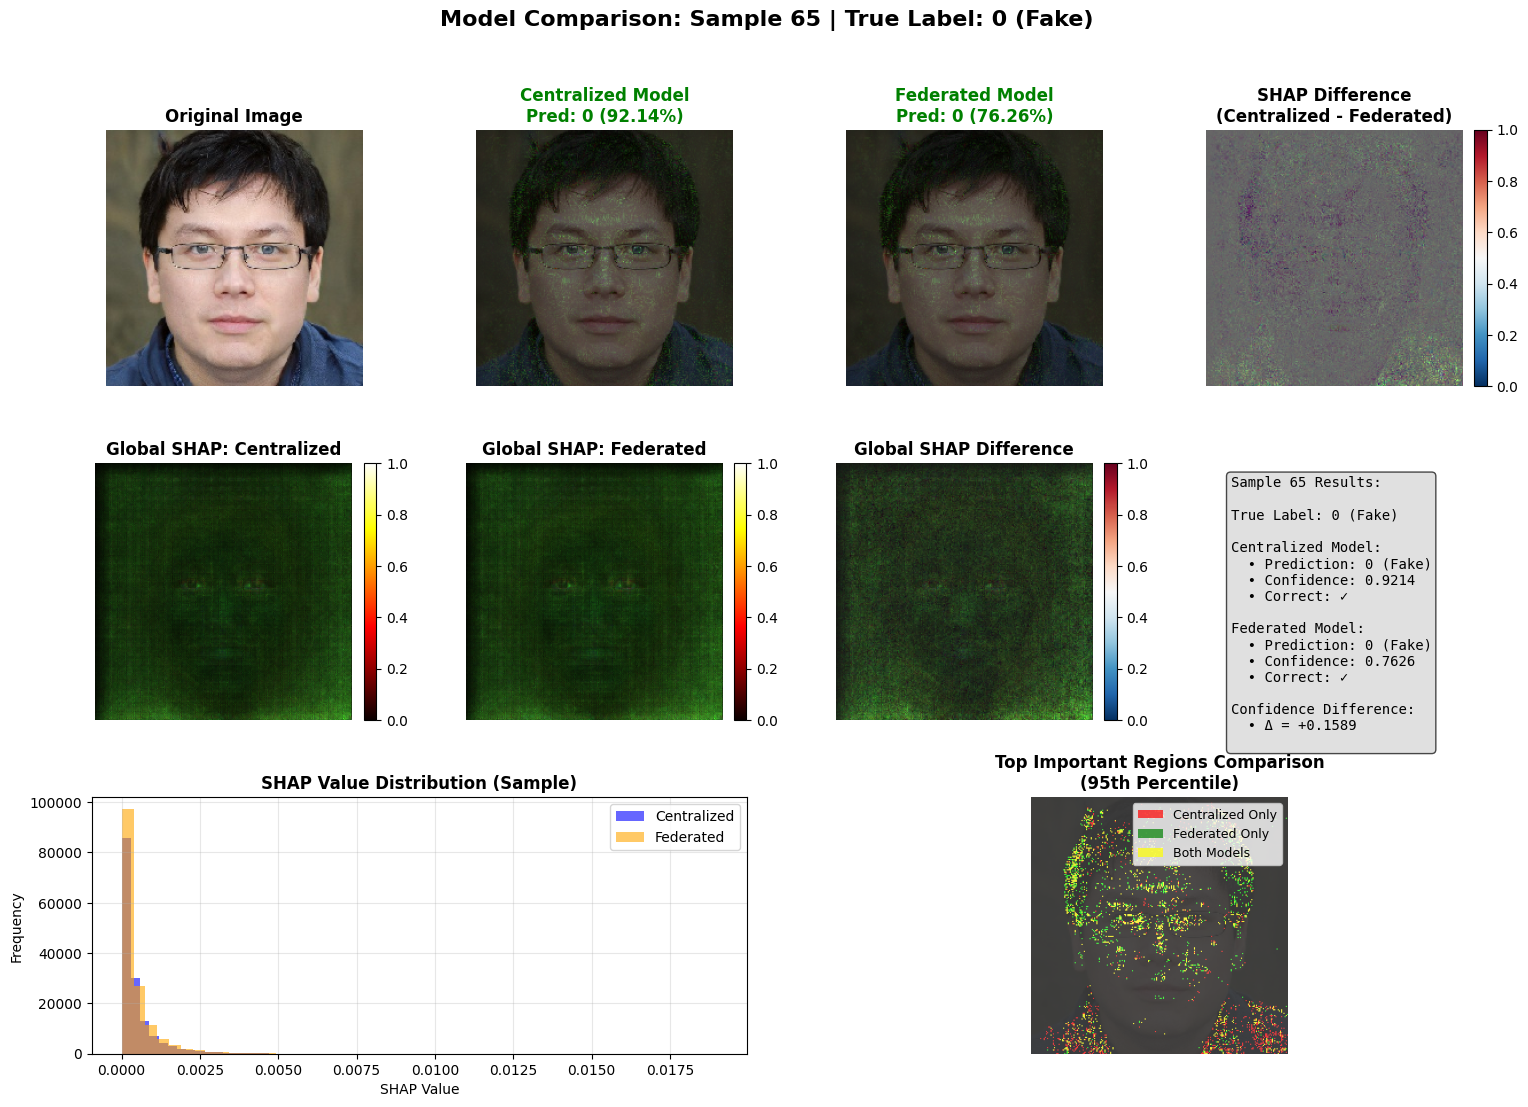

SAMPLE 65 - DETAILED ANALYSIS
True Label: 0 | Centralized Prediction: 0 | Federated Prediction: 0
Confidence: Centralized=0.9214, Federated=0.7626
Confidence Difference (Δ): +0.1589

SHAP Statistics:
  Centralized Sample Range: [0.000000, 0.014698]
  Federated Sample Range: [0.000000, 0.018997]
  Global Central SHAP Range: [0.000021, 0.004396]
  Global Federated SHAP Range: [0.000017, 0.003158]
  SHAP Map Correlation: 0.8293
  Top Region Agreement: 96.32%

Additional Metrics:
  Mean SHAP Difference: 0.000228
  Max SHAP Difference: 0.006383
  Fraction of pixels where both agree on top 5%: 3.16%



In [104]:
fig = visualize_comparison(
    idx= 65 , # or any index you want to analyze
    X_test=X_test,
    y_test=y_test,
    centralized_model=centralized_model,
    federated_model=federated_model,
    shap_central=shap_central,
    shap_federated=shap_federated,
    global_shap_central=global_shap_central,
    global_shap_federated=global_shap_federated
)

##  Sample were both models are correct - (Prediction Real or 1)

/tmp/ipython-input-622681809.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


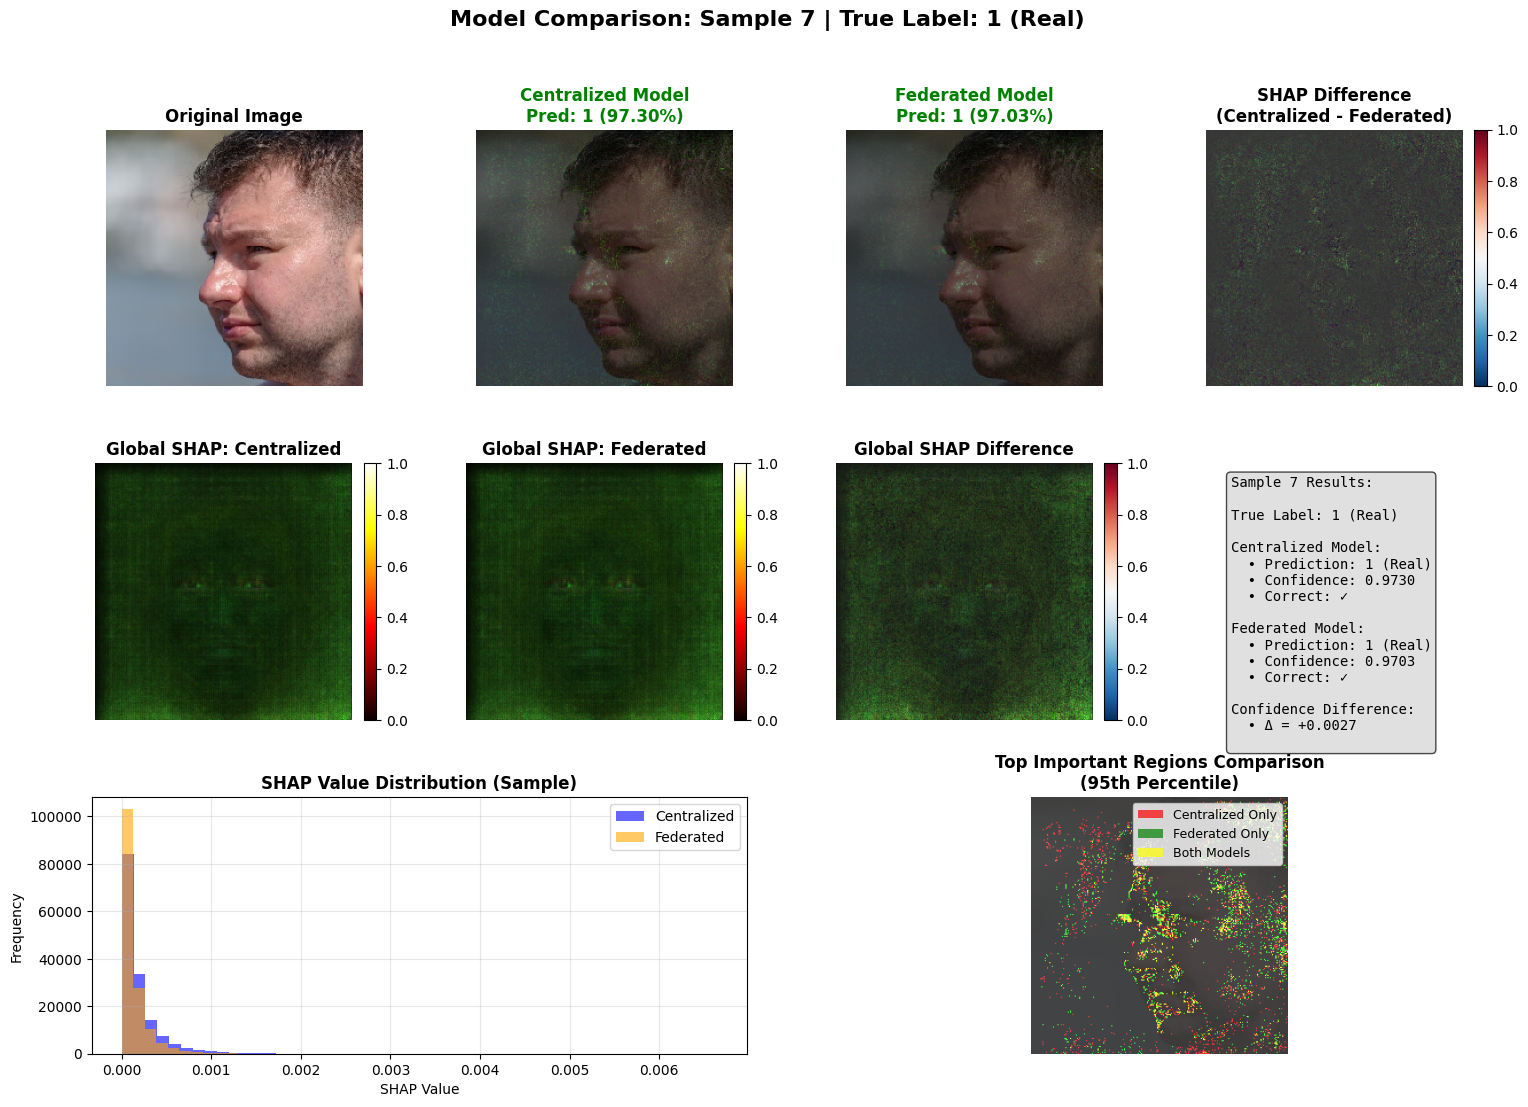

SAMPLE 7 - DETAILED ANALYSIS
True Label: 1 | Centralized Prediction: 1 | Federated Prediction: 1
Confidence: Centralized=0.9730, Federated=0.9703
Confidence Difference (Δ): +0.0027

SHAP Statistics:
  Centralized Sample Range: [0.000000, 0.006643]
  Federated Sample Range: [0.000000, 0.006445]
  Global Central SHAP Range: [0.000021, 0.004396]
  Global Federated SHAP Range: [0.000017, 0.003158]
  SHAP Map Correlation: 0.5575
  Top Region Agreement: 94.21%

Additional Metrics:
  Mean SHAP Difference: 0.000126
  Max SHAP Difference: 0.005244
  Fraction of pixels where both agree on top 5%: 2.11%



In [105]:
fig = visualize_comparison(
    idx= 7 , # or any index you want to analyze
    X_test=X_test,
    y_test=y_test,
    centralized_model=centralized_model,
    federated_model=federated_model,
    shap_central=shap_central,
    shap_federated=shap_federated,
    global_shap_central=global_shap_central,
    global_shap_federated=global_shap_federated
)